<a href="https://colab.research.google.com/github/Samuelameningayeh/thesis/blob/main/synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cmdstanpy
cmdstanpy.install_cmdstan()


/home/samuela/Documents/thesis/myvenv/thesis/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /home/samuela/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpv3ixw5xo
Extracting distribution
Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.
Installed cmdstan-2.36.0
Test model compilation


True

In [604]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
from pathlib import Path

from loadData import load_data
from imputeMissing import impute_value

from scipy.integrate import odeint

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# Define the SEIR model

In [207]:
# ---- SEIR ODE system --------------------------------------------------------
def seir(state, t, beta, sigma, gamma, N):
    n=len(N)
    S = state[:n]
    E = state[n:2*n]
    I = state[2*n:3*n]
    R = state[3*n:4*n]
    C = state[4*n:5*n]
    # C = y[5*n*n:].reshape(n, n)

    dS = np.zeros(n)
    dE = np.zeros(n)
    dI = np.zeros(n)
    dR = np.zeros(n)
    # dD = np.zeros(n)
    dC = np.zeros(n)
    
    for i in range(n):
        dS[i] = -beta[i] * S[i] * I[i] / N[i]
        dE[i] =  beta[i] * S[i] * I[i] / N[i] - sigma * E[i]
        dI[i] =  sigma * E[i] - gamma * I[i]
        dR[i] =  gamma * I[i]
        dC[i] = sigma * E[i]
    
    return np.concatenate([dS.flatten(), dE.flatten(), dI.flatten(), dR.flatten(), dC.flatten()])


# Define Parameters

In [784]:
n_regions = 3 
T = 450 
# Time vector
t = np.linspace(0, T-1, T)

N = [11.5e6, 4.5e6, 6.8e6]  # Guinea, Liberia, Sierra Leone
# N=[4e6, 2.5e6, 2e6]

## Get the Parameters
beta = [0.3, 0.4, 0.35]  # Transmission rate (R0 = beta/gamma)
sigma = 1/10         # 1/latent period (Ebola: ~10 days) Average value
gamma = 1/7         # 1/infectious period (Ebola: ~7 days)
phi = 10            # Negative binomial dispersion parameter
reporting_rate = 0.8  # Proportion of cases reported

## Get initials
# guinea = [N[0]-1000, 0, 1000, 0, 1000]
# lib = [N[1]-100, 0, 100, 0, 100]
# sir = [N[2]-100, 0, 100, 0, 100]

# Initial conditions
E0 = np.array([10, 10, 10])
I0 = np.array([1000, 100, 100])
R0 = np.array([0,0,0])
C0 = np.array([1000, 100, 100])
S0 = np.array([N[0]-1000, N[1]-100, N[2]-100])

# initial_state = [guinea, lib, sir]
y0 = np.concatenate([S0.flatten(), E0.flatten(), I0.flatten(), R0.flatten(), C0.flatten()])


# Solve the ODEs

In [269]:
# Simulate SEIR for each region
sol = odeint(seir, y0, t, args=(beta, sigma, gamma, N))

In [270]:
sol[:, :3]

array([[11499000.        ,  4499900.        ,  6799900.        ],
       [11498718.96824573,  4499862.29896023,  6799867.03794091],
       [11498467.67828842,  4499827.94990909,  6799837.15195997],
       ...,
       [ 2045976.72440174,   337602.01713374,   776103.00635537],
       [ 2045976.15968902,   337602.01693187,   776102.9873652 ],
       [ 2045975.61998374,   337602.01674226,   776102.96938573]],
      shape=(450, 3))

In [271]:
n = 3
# Extract and aggregate results
# S = sol[:, :n]
# E = sol[:, n:2*n]
# I = sol[:, 2*n:3*n]
# R = sol[:, 3*n:4*n]
# D = sol[:, 4*n:]

## Total per patch (sum over resident patches i)
S_total = sol[:, :n]
E_total = sol[:, n:2*n]
I_total = sol[:, 2*n:3*n]
R_total = sol[:, 3*n:4*n]
C_total = sol[:, 4*n:]

## get the new infected individuals at each time
Infections = np.zeros([T, n])
for j in range(3):
    # new_infections = []
    for i in (range(len(C_total))):

        if (i+1 == len(C_total)):
            new_infections = [0.0,0.0,0.0]
            Infections[i, j] = new_infections[j]
        else:
            new_infections = C_total[i+1] - C_total[i]
            Infections[i+1, j] = new_infections[j]

## Show New infections

In [272]:
Infections

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.48287506e+01, 2.80907520e+00, 2.57624347e+00],
       [3.86324377e+01, 5.95359394e+00, 5.30799018e+00],
       ...,
       [1.08009444e+00, 5.74709848e-04, 4.42692321e-02],
       [1.03226426e+00, 5.39832748e-04, 4.19130949e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(450, 3))

## Add Noise

In [581]:
## Function to add noise
def Add_noise(data, reporting_rate):
    observed_cases = []
    for i in range(len(np.array(data))):
        case = []
        for t in range(len(np.array(data)[i])):
            mean_cases = reporting_rate * np.array(data)[i][t]

            # Negative binomial: r = phi (dispersion), p = phi/(phi + mean)
            p = phi / (phi + mean_cases)
            case.append(np.random.negative_binomial(phi, p))
        observed_cases.append(case)
    return np.array(observed_cases)

observed_cases = Add_noise(Infections, reporting_rate= reporting_rate)
b = pd.DataFrame(observed_cases, columns = ['Guinea', 'Liberia', 'Sierra Leone'])
b.head()

,Guinea,Liberia,Sierra Leone
0,0,0,0
1,6,4,2
2,44,2,7
3,96,11,6
4,61,7,5


## Create a dataframe

In [785]:
# Create dataset
data = {
    'time': pd.date_range(start='2013-12-28', periods=T, freq='D'),
    'Day': t.astype(int),
    'S_Guinea': S_total[:, 0],
    'E_Guinea': E_total[:, 0],
    'I_Guinea': I_total[:, 0],
    'R_Guinea': R_total[:, 0],
    'C_Guinea': C_total[:, 0],
    'Guinea_New_case': Infections[:, 0],
    'Guinea_Noise' : b['Guinea'],

    'S_Liberia': S_total[:, 1],
    'E_Liberia': E_total[:, 1],
    'I_Liberia': I_total[:, 1],
    'R_Liberia': R_total[:, 1],
    'C_Liberia': C_total[:, 1],
    'Liberia_New_case': Infections[:, 1],
    'Liberia_Noise' : b['Liberia'],

    'S_SierraLeone': S_total[:, 2],
    'E_SierraLeone': E_total[:, 2],
    'I_SierraLeone': I_total[:, 2],
    'R_SierraLeone': R_total[:, 2],
    'C_SierraLeone': C_total[:, 2],
    'SierraLeone_New_case': Infections[:, 2],
    'SierraLeone_Noise' : b['Sierra Leone'],
}

raw = pd.DataFrame(data)
# df.to_csv('synthetic_ebola_dataset_with_death.csv', index=False)
raw.head()

,time,Day,S_Guinea,E_Guinea,I_Guinea,R_Guinea,C_Guinea,Guinea_New_case,Guinea_Noise,S_Liberia,...,C_Liberia,Liberia_New_case,Liberia_Noise,S_SierraLeone,E_SierraLeone,I_SierraLeone,R_SierraLeone,C_SierraLeone,SierraLeone_New_case,SierraLeone_Noise
0,2013-12-28,0,1.149900e+07,10.000000,1000.000000,0.000000,1000.000000,0.000000,0,4.499900e+06,...,100.000000,0.000000,0,6.799900e+06,10.000000,100.000000,0.000000,100.000000,0.000000,0
1,2013-12-29,1,1.149872e+07,276.203004,880.990832,133.837918,1014.828751,14.828751,6,4.499862e+06,...,102.809075,2.809075,4,6.799867e+06,40.385816,89.122111,13.454132,102.576243,2.576243,2
2,2013-12-30,2,1.149847e+07,488.860523,799.946747,253.514442,1053.461188,38.632438,44,4.499828e+06,...,108.762669,5.953594,2,6.799837e+06,64.963806,82.231477,25.652757,107.884234,5.307990,7
3,2013-12-31,3,1.149824e+07,662.488695,747.549440,363.754479,1111.303919,57.842730,96,4.499795e+06,...,117.318953,8.556283,11,6.799809e+06,85.439019,78.341428,37.091304,115.432732,7.548499,6
4,2014-01-01,4,1.149802e+07,807.928057,716.889990,468.132314,1185.022304,73.718385,61,4.499764e+06,...,128.112467,10.793515,7,6.799782e+06,103.073270,76.733318,48.144377,124.877695,9.444963,5


# Plot the results

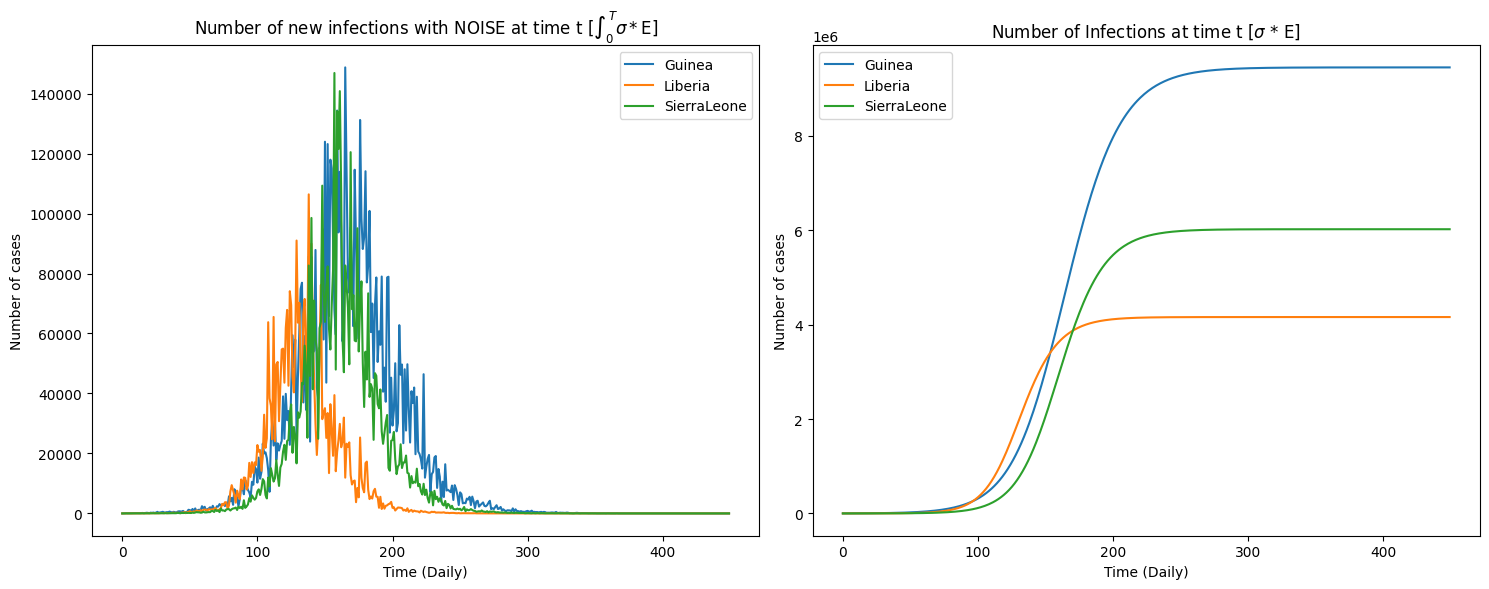

In [590]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
countries = ['Guinea', 'Liberia', 'SierraLeone']
for i in range(3):
    ax[0].plot(raw[f'{countries[i]}_Noise'])
    ax[0].legend(countries)
    ax[0].set_title('Number of new infections with NOISE at time t $[\int_0^T \sigma*$E]')
    ax[0].set_xlabel('Time (Daily)')
    ax[0].set_ylabel('Number of cases')

    ax[1].plot(raw[f'C_{countries[i]}'])
    ax[1].legend(countries)
    ax[1].set_title('Number of Infections at time t [$ \sigma$ * E]')
    ax[1].set_xlabel('Time (Daily)')
    ax[1].set_ylabel('Number of cases')

plt.tight_layout()
plt.show()

In [595]:
# Plot for each country
countries = ['Guinea', 'Liberia', 'SierraLeone']
def plot_SEIR(df, country_name, Death = False, save=False, yscale = True):
    # Extract data for the current country
    S = df[f'S_{country_name}']
    E = df[f'E_{country_name}']
    I = df[f'I_{country_name}']
    R = df[f'R_{country_name}']

    # Create plot
    plt.figure(figsize=(13, 6))
    plt.plot(df['Date'], S, label='Susceptible', color='blue')
    plt.plot(df['Date'], E, label='Exposed', color='orange')
    plt.plot(df['Date'], I, label='Infective', color='red')
    plt.plot(df['Date'], R, label='Recovered', color='green')
    if Death:
        D = df[f'D_{country_name}']
        plt.plot(df['Date'], D, label='Death', color='black')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Number of Individuals')
    plt.title(f'SEIRD Dynamics for {country_name}')
    plt.legend()
    plt.grid(True)
    if yscale:
        plt.yscale('symlog')  # Use symlog scale to handle large ranges
    if save:
        plt.savefig(f'seird_{country_name.lower()}.png')
    plt.show()

In [803]:
# plot_SEIR(raw, 'Guinea')

# Aggregate the Data from daily cases to weekly cases

## Aggregate the Data

In [ ]:
# def Aggregate_data(data):
#     # Convert the 'time' column to datetime format, assuming it represents days since 2014-01-01
#     # data["time"] = pd.Timestamp("2014-01-01") + pd.to_timedelta(data["time"], unit="D")

#     ## get patches
#     patch_names = ["Guinea", "Liberia", "Sierra Leone"]
#     n_patches = len(patch_names)

#     ## Set the start date and end of the date
#     start_date =  data["time"].min()
#     end_date = data["time"].max()
#     weeks = pd.date_range(start=start_date, end=end_date, freq="W-MON")
#     T = len(weeks)

#     ## Create an empty array to store observed cases
#     I_obs = np.zeros((T, n_patches))

#     ## Fill the observed cases array with weekly data for each patch
#     for i, country in enumerate(patch_names):
#         country_data = data[data["country"] == country]
#         weekly_cases = country_data.groupby(pd.Grouper(key="time", freq="W-MON"))['cases'].sum()
#         # weekly_cases.index = pd.to_datetime(weekly_cases.index)
#         weekly_cases = weekly_cases.reindex(weeks, fill_value=0)
#         I_obs[:, i] = weekly_cases.values

#     ## Create a DataFrame for plotting
#     time = np.arange(1, T + 1)
#     Cases = pd.DataFrame(I_obs, columns=patch_names)
#     Cases["Time"] = time
#     Cases["Week"] = weeks[:].strftime("%Y-%m-%d")

#     # Melt the DataFrame for easier plotting
#     Cases = Cases.melt(id_vars=["Time", "Week"], var_name="Patches", value_name="Cases")

#     return Cases

In [ ]:
df2 = raw[['time','Guinea_New_case', 'Liberia_New_case', 'SierraLeone_New_case']]
weekly_cases = df2.groupby(pd.Grouper(key="time", freq="W-MON"))[['Guinea_New_case', 'Liberia_New_case', 'SierraLeone_New_case']].sum()

## Add the noise to the data

In [821]:
def add_nb_noise(series, dispersion=10):
    # Ensure the series contains only numeric values
    series = pd.to_numeric(series, errors='coerce')  # Convert non-numeric to NaN
    series = series.fillna(0)  # Replace NaN with 0 (or handle it as needed)

    mu = series.values
    r = dispersion
    p = r / (r + mu)  # NB2 parameterization

    noisy = np.random.negative_binomial(n=r, p=p)
    return pd.Series(noisy, index=series.index)


In [829]:
weekly_cases = weekly_cases.reset_index(drop=True)

# Apply to all three columns
noisy_cases = weekly_cases.copy()
for col in noisy_cases.columns:
    noisy_cases[col] = add_nb_noise(noisy_cases[col], dispersion=10)

noisy_cases.head()

,Guinea_New_case,Liberia_New_case,SierraLeone_New_case
0,54,7,6
1,742,109,80
2,808,136,235
3,1904,214,155
4,2817,304,253


## Plot them

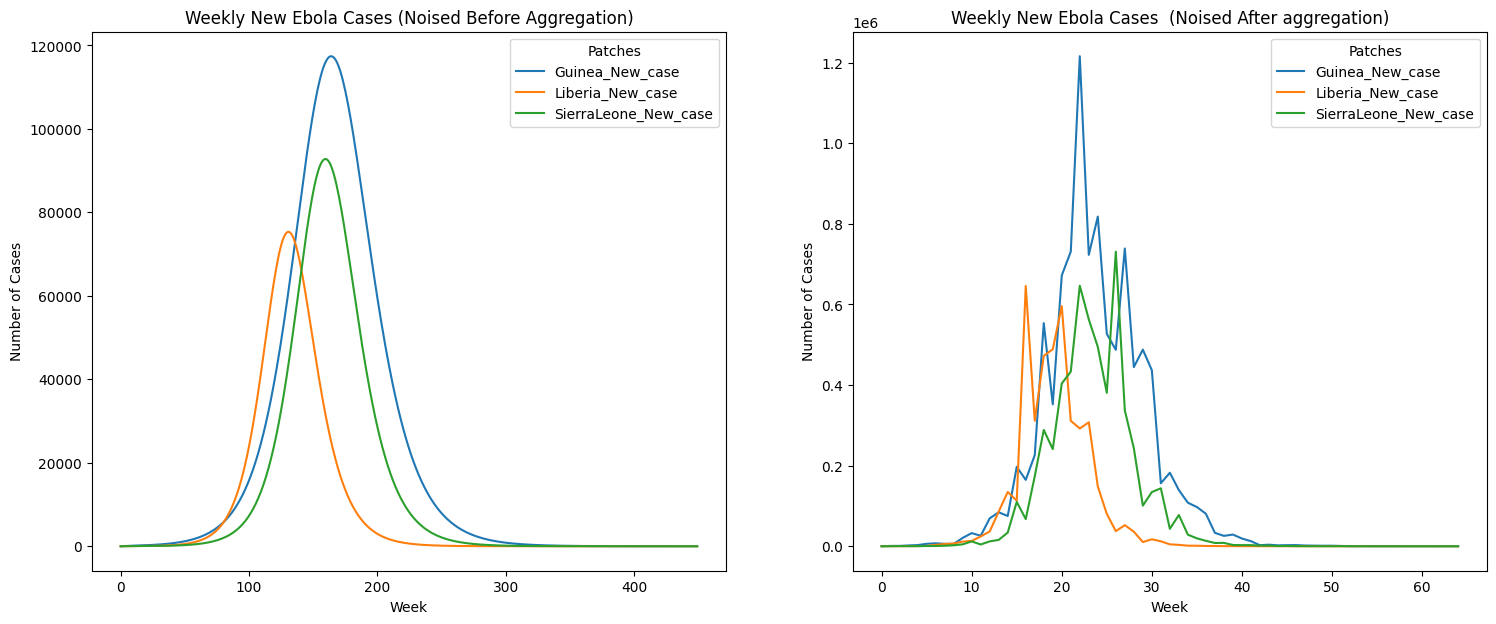

In [830]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ct =['Guinea_New_case', 'Liberia_New_case', 'SierraLeone_New_case']

# Plot each patch separately
for patch in ct:
    ax[0].plot(raw['Day'], raw[patch], label=patch)
ax[0].set_title("Weekly New Ebola Cases (Noised Before Aggregation)")
ax[0].set_xlabel("Week")
ax[0].set_ylabel("Number of Cases")
ax[0].legend(title="Patches")

for patch in ct:
    ax[1].plot(noisy_cases.index, noisy_cases[patch], label=patch)
ax[1].set_title("Weekly New Ebola Cases  (Noised After aggregation)")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Number of Cases")
ax[1].legend(title="Patches")
# plt.grid(True)
# plt.savefig('./images/weekly_cases.pdf', bbox_inches='tight')
plt.show()

# Create a function to plot Posterior for Parameters

In [764]:
import math

def plot_posterior_kde_grid(fit:any, parameters: list, n_rows: int, n_cols: int, true_values: dict = None):
    """
    Plot KDEs of posterior samples for given parameters from a CmdStanMCMC fit.

    Args:
        fit (CmdStanMCMC): The fitted model.
        parameters (list of str): Names of parameters to plot.
        n_rows (int): Number of subplot rows.
        n_cols (int): Number of subplot columns.
        true_values (dict, optional): Dict mapping param names to true values for reference lines.
    """
    posterior_samples = fit.draws_pd()
    
    # Dynamically calculate the number of rows
    n_params = len(parameters)
    n_rows = math.ceil(n_params / n_cols)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
    ax = ax.flatten()  # flatten axes for easy indexing

    for i, param in enumerate(parameters):
        if param in posterior_samples.columns:
            sns.kdeplot(posterior_samples[param], fill=True, ax=ax[i])
            if true_values and param in true_values:
                ax[i].axvline(x=true_values[param], color='r', linestyle='--', label='True value')
                ax[i].legend()
            ax[i].set_xlabel(param)
            ax[i].set_ylabel('Density')
            ax[i].set_title(f'Posterior of {param}')
        else:
            ax[i].text(0.5, 0.5, f"{param} not found", ha='center', va='center')
            ax[i].axis('off')

    # Hide unused axes
    for j in range(len(parameters), len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()


# Fit the Model to only Guinea

In [598]:
# Aggregate cases by country and week
countries = ['Guinea', 'Liberia', 'Sierra Leone']
# weekly_cases = df.groupby(['country', pd.Grouper(key='time', freq='W')]).sum().unstack(fill_value=0).T
weekly_cases1 = raw['Guinea_Noise']
weekly_cases2 = raw['Liberia_Noise']
weekly_cases3 = raw['SierraLeone_Noise']

cases1 = weekly_cases1.values  # Shape: (T, 3)
cases2 = weekly_cases2.values  # Shape: (T, 3)
cases3 = weekly_cases3.values  # Shape: (T, 3)

N = np.array([11.5e6, 4.5e6, 6.8e6]) 
# Set the population size
# N = n[0] #763

# Define initial conditions
i0 = [1000, 100, 100]
e0 = [10, 10, 10]
s0 = N - i0
r0 = [0, 0, 0]
c0 = [0, 0, 0]
y1 = [s0[0], e0[0], i0[0], r0[0], c0[0]]
y2 = [s0[1], e0[1], i0[1], r0[1], c0[1]]
y3 = [s0[2], e0[2], i0[2], r0[2], c0[2]]


In [ ]:

# Make the data struture
seir_data1 = {
    "n_days": len(cases1),
    "y0": y1,
    "t0": 0,
    "t": np.arange(1, len(cases1)+1),
    "N": int(N[0]),
    "cases": cases1
}

seir_data2 = {
    "n_days": len(cases2),
    "y0": y2,
    "t0": 0,
    "t": np.arange(1, len(cases2)+1),
    "N": int(N[1]),
    "cases": cases2
}
seir_data3 = {
    "n_days": len(cases3),
    "y0": y3,
    "t0": 0,
    "t": np.arange(1, len(cases3)+1),
    "N": int(N[2]),
    "cases": cases3
}

seir_incidence_model = CmdStanModel(stan_file = 'stan files/guinea.stan')
# seir_incidence_model1 = CmdStanModel(stan_file = 'stan files/lib.stan')
# seir_incidence_model2 = CmdStanModel(stan_file = 'stan files/sierra.stan')

In [660]:
fit_seir_incidence_model = seir_incidence_model.sample(data = seir_data1,
                                                       iter_warmup= 500,
                                                       iter_sampling = 1000,
                                                       chains = 4,
                                                       seed = 0)















































































































































































































































































































chain 1 |██████████| 23:21 Sampling completed                       
chain 2 |██████████| 23:21 Sampling completed                       
chain 3 |██████████| 23:21 Sampling completed                       
chain 4 |██████████| 23:21 Sampling completed                       

In [661]:
fit2 = seir_incidence_model1.sample(data = seir_data2,
                                    iter_warmup= 500,
                                   iter_sampling = 1000,
                                   chains = 4,
                                   seed = 0)






























































































































































































































































































































chain 1 |██████████| 19:58 Sampling completed                       
chain 2 |██████████| 19:58 Sampling completed                       
chain 3 |██████████| 19:58 Sampling completed                       
chain 4 |██████████| 19:58 Sampling completed                       

In [662]:
fit3 = seir_incidence_model2.sample(data = seir_data3,
                                    iter_warmup= 500,
                                   iter_sampling = 1000,
                                   chains = 4,
                                   seed = 0)





































































































































































































































































































































chain 1 |██████████| 12:47 Sampling completed                       
chain 2 |██████████| 12:47 Sampling completed                       
chain 3 |██████████| 12:47 Sampling completed                       
chain 4 |██████████| 12:47 Sampling completed                       

In [713]:
seir_incidence_summary = fit_seir_incidence_model.summary()
seir_incidence_summary.filter(items=("sigma", "beta", "recovery_time", "gamma", "incubation_period", "R0", "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
sigma,0.109122,0.000404,0.012453,0.011725,0.091722,0.107199,0.132690,1025.820,1272.61,1.00501
beta,0.231789,0.000782,0.022241,0.021824,0.201794,0.228065,0.273822,882.699,1212.85,1.00637
recovery_time,9.278270,0.032005,1.012300,1.030820,7.536370,9.328470,10.902600,1025.820,1272.61,1.00501
gamma,0.123684,0.000397,0.013214,0.013884,0.103212,0.122938,0.146380,1125.910,2096.53,1.00429
incubation_period,8.177800,0.026728,0.875185,0.916810,6.831510,8.134190,9.688800,1125.910,2096.53,1.00429
R0,2.129870,0.001677,0.088829,0.086361,1.992410,2.125570,2.280880,2827.990,2148.60,1.00182
phi,9.264030,0.016776,0.686269,0.688445,8.160610,9.257890,10.434600,1671.520,1958.83,1.00133
phi_inv,0.108538,0.000196,0.008053,0.008091,0.095835,0.108016,0.122540,1671.540,1958.83,1.00158


In [714]:
fit2_summary = fit2.summary()
fit2_summary.filter(items=("sigma", "beta", "recovery_time", "gamma", "incubation_period", "R0", "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
sigma,0.124970,0.000659,0.019894,0.020690,0.098109,0.122107,0.161505,946.693,1497.220,1.00336
beta,0.347964,0.001428,0.038110,0.039823,0.285096,0.347901,0.410093,702.231,743.492,1.00260
recovery_time,8.195110,0.040634,1.237170,1.386100,6.191770,8.189540,10.192700,946.703,1497.220,1.00317
gamma,0.112404,0.000497,0.012679,0.008684,0.098449,0.109712,0.137156,981.145,632.373,1.00172
incubation_period,8.992510,0.031400,0.867239,0.732397,7.290940,9.114800,10.157500,981.137,632.373,1.00172
R0,2.808750,0.005016,0.203235,0.209291,2.482530,2.802990,3.159260,1627.140,1502.170,1.00208
phi,7.742540,0.016186,0.698106,0.704910,6.618990,7.715730,8.910980,1885.790,1745.880,1.00073
phi_inv,0.130210,0.000271,0.011780,0.011865,0.112221,0.129605,0.151080,1885.790,1745.880,1.00087


In [712]:
fit3_summary = fit3.summary()
fit3_summary.filter(items=("sigma", "beta", "recovery_time", "gamma", "incubation_period", "R0", "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
sigma,0.104689,0.000239,0.008921,0.008745,0.092178,0.103468,0.120536,1551.05,1517.54,1.00147
beta,0.279766,0.000452,0.016994,0.016269,0.253635,0.278417,0.309839,1444.39,1413.30,1.00053
recovery_time,9.618880,0.020458,0.790032,0.823228,8.296240,9.664820,10.848600,1551.09,1517.54,1.00152
gamma,0.106634,0.000166,0.007665,0.006985,0.095915,0.105669,0.120709,2352.22,1855.00,1.00020
incubation_period,9.424280,0.013697,0.649442,0.628830,8.284380,9.463540,10.425900,2352.19,1855.00,1.00020
R0,2.679590,0.002502,0.120147,0.123063,2.485060,2.676570,2.882380,2303.16,2265.73,1.00055
phi,12.335100,0.023674,1.025730,1.027220,10.722300,12.278200,14.076500,1876.22,2059.69,1.00011
phi_inv,0.081632,0.000158,0.006813,0.006797,0.071040,0.081445,0.093264,1876.21,2059.69,1.00039


chain 1 |          | 3:18:22 Status
chain 2 |▍         | 3:18:22 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 3 |▍         | 3:18:22 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 4 |▉         | 3:18:22 Iteration:  100 / 2000 [  5%]  (Warmup)


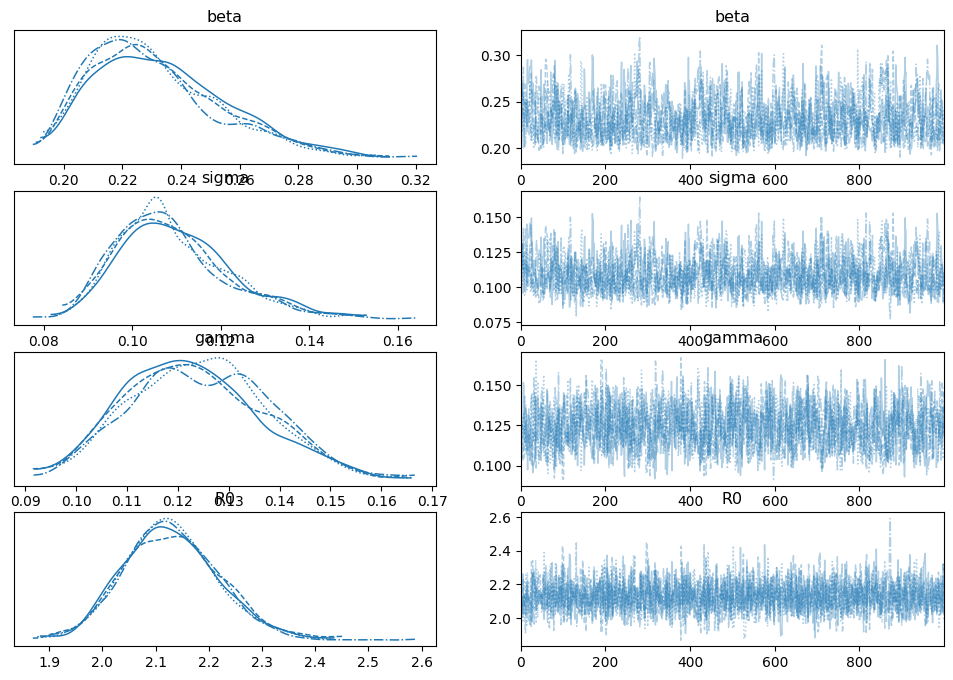

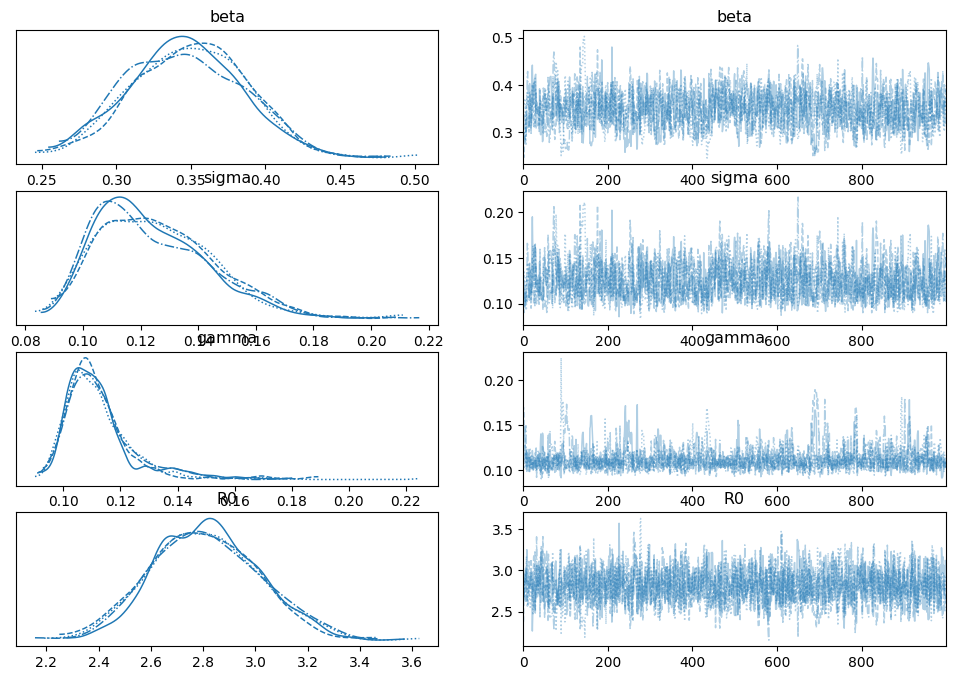

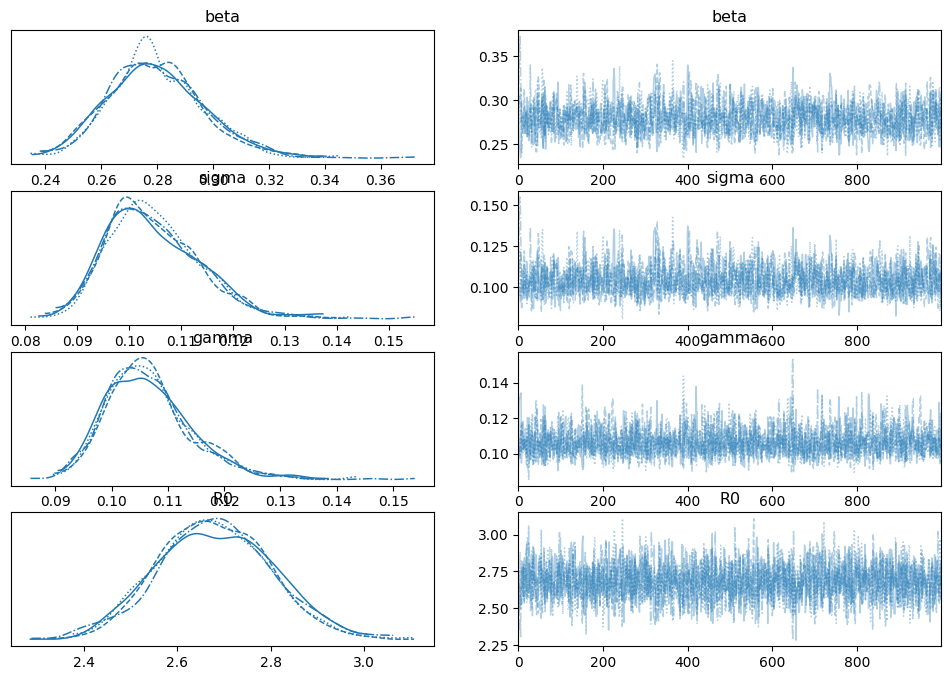

In [666]:
## trace plots
az.plot_trace(fit_seir_incidence_model, var_names=["beta", "sigma", "gamma", "R0"])
az.plot_trace(fit2, var_names=["beta", "sigma", "gamma", "R0"])
az.plot_trace(fit3, var_names=["beta", "sigma", "gamma", "R0"])
plt.show()

# Posterior Predictive Checks

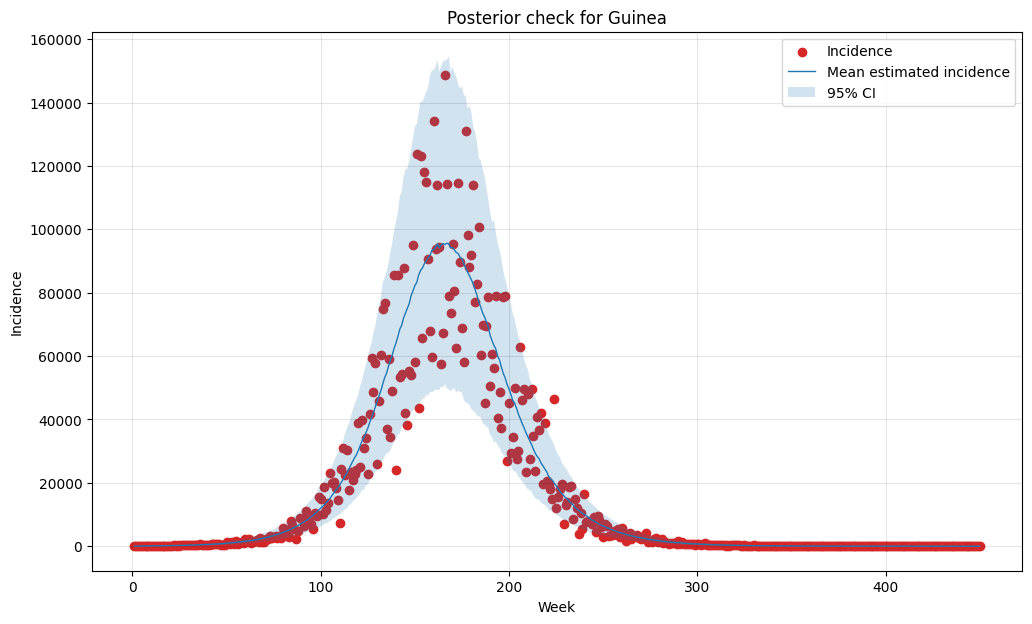

In [667]:
post_pred = pd.DataFrame(seir_incidence_summary.filter(like="pred_incidence", axis=0))
post_pred["t"] = range(1, 451)
post_pred["incidence"] = list(cases1)
post_pred = post_pred.set_index("t")

plt.figure(figsize=(12, 7))
plt.grid(True, which='both', color = 'k', alpha = 0.1)
plt.title(f'Posterior check for Guinea')
plt.ylabel('Incidence')
plt.xlabel('Week')
plt.scatter(x = post_pred.index, y = post_pred.incidence, color = 'tab:red', label = "Incidence")
plt.plot(post_pred.Mean, color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
plt.fill_between(x = post_pred.index, y1 = post_pred['5%'], y2 = post_pred['95%'], alpha=0.2, label="95% CI")
# plt.facecolor('white')
plt.legend(loc = "upper right")

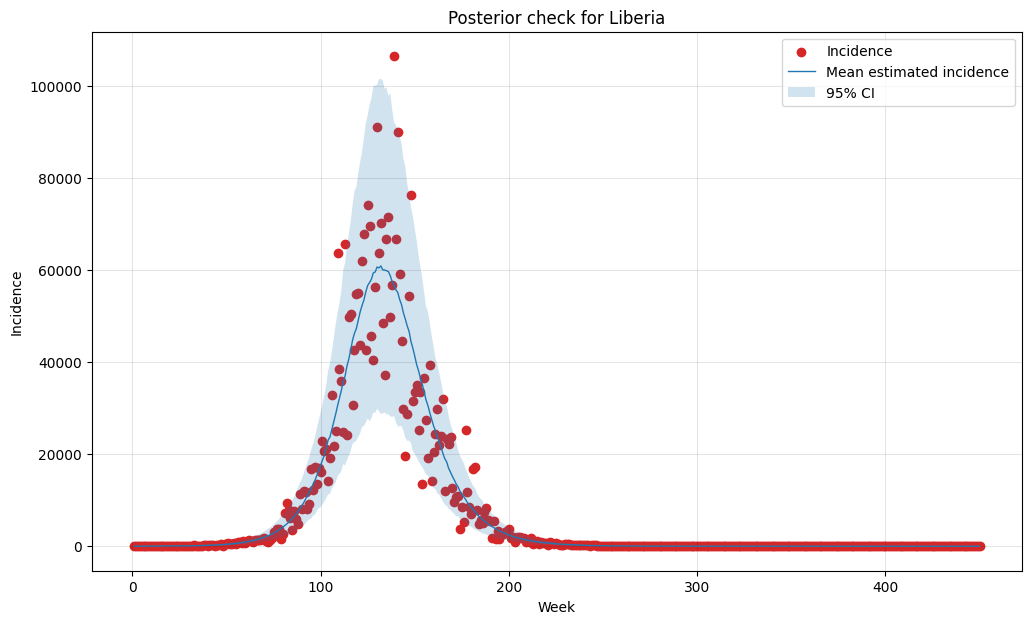

In [668]:
post_pred2 = pd.DataFrame(fit2_summary.filter(like="pred_incidence", axis=0))
post_pred2["t"] = range(1, 451)
post_pred2["incidence"] = list(cases2)
post_pred2 = post_pred2.set_index("t")

plt.figure(figsize=(12, 7))
plt.grid(True, which='both', color = 'k', alpha = 0.1)
plt.title(f'Posterior check for Liberia')
plt.ylabel('Incidence')
plt.xlabel('Week')
plt.scatter(x = post_pred2.index, y = post_pred2.incidence, color = 'tab:red', label = "Incidence")
plt.plot(post_pred2.Mean, color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
plt.fill_between(x = post_pred2.index, y1 = post_pred2['5%'], y2 = post_pred2['95%'], alpha=0.2, label="95% CI")
# plt.facecolor('white')
plt.legend(loc = "upper right")

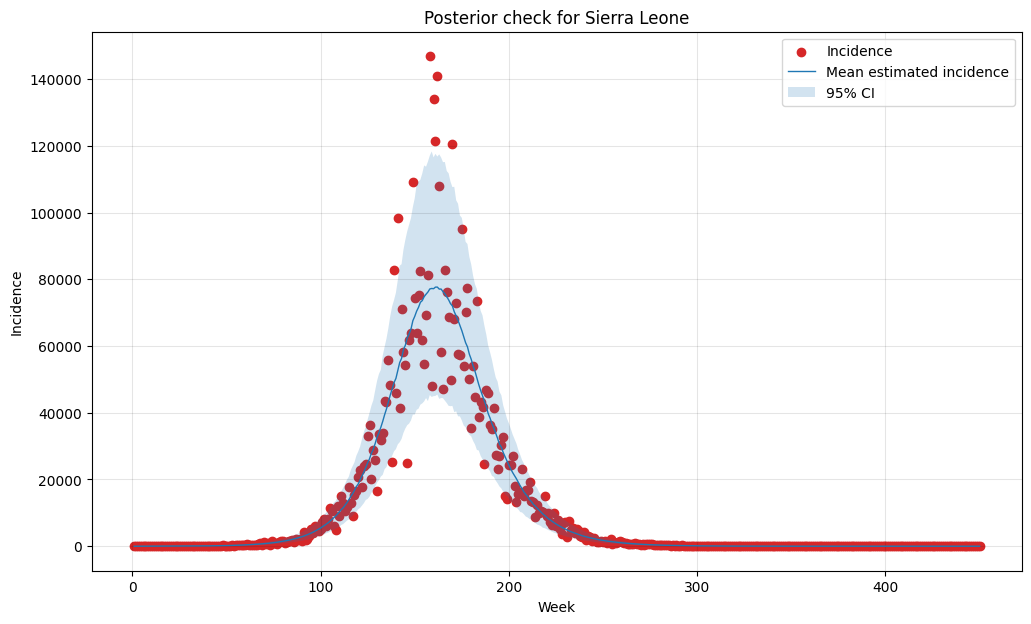

In [669]:
post_pred3 = pd.DataFrame(fit3_summary.filter(like="pred_incidence", axis=0))
post_pred3["t"] = range(1, 451)
post_pred3["incidence"] = list(cases3)
post_pred3 = post_pred3.set_index("t")

plt.figure(figsize=(12, 7))
plt.grid(True, which='both', color = 'k', alpha = 0.1)
plt.title(f'Posterior check for Sierra Leone')
plt.ylabel('Incidence')
plt.xlabel('Week')
plt.scatter(x = post_pred3.index, y = post_pred3.incidence, color = 'tab:red', label = "Incidence")
plt.plot(post_pred3.Mean, color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
plt.fill_between(x = post_pred3.index, y1 = post_pred3['5%'], y2 = post_pred3['95%'], alpha=0.2, label="95% CI")
# plt.facecolor('white')
plt.legend(loc = "upper right")

In [765]:
# Assuming `fit` is your CmdStanMCMC object from fitting the model
parameters1 = ["beta", "sigma", "recovery_time", "gamma", "incubation_period", "R0","phi"]

beta = np.array([0.3, 0.4, 0.35])  # Transmission rate (R0 = beta/gamma)
sigma = 1/10         # 1/latent period (Ebola: ~10 days) Average value
gamma = 1/7         # 1/infectious period (Ebola: ~7 days)
phi = 10            # Negative binomial dispersion parameter
reporting_rate = 0.8
r = beta/sigma
rec = 1.0/sigma
incu = 1.0 / gamma

t1 = {'beta':beta[0],'sigma': 1/10, 'gamma': 1/7, 'phi': 10 ,
    'reporting_rate':0.8, 'R0': r[0], 'recovery_time':rec,
    'incubation_period': incu}

t2 = {'beta':beta[1],'sigma': 1/10, 'gamma': 1/7, 'phi': 10 ,
    'reporting_rate':0.8, 'R0': r[1], 'recovery_time':rec,
    'incubation_period': incu}

t3 = {'beta':beta[1],'sigma': 1/10, 'gamma': 1/7, 'phi': 10 ,
    'reporting_rate':0.8, 'R0': r[1], 'recovery_time':rec,
    'incubation_period': incu}

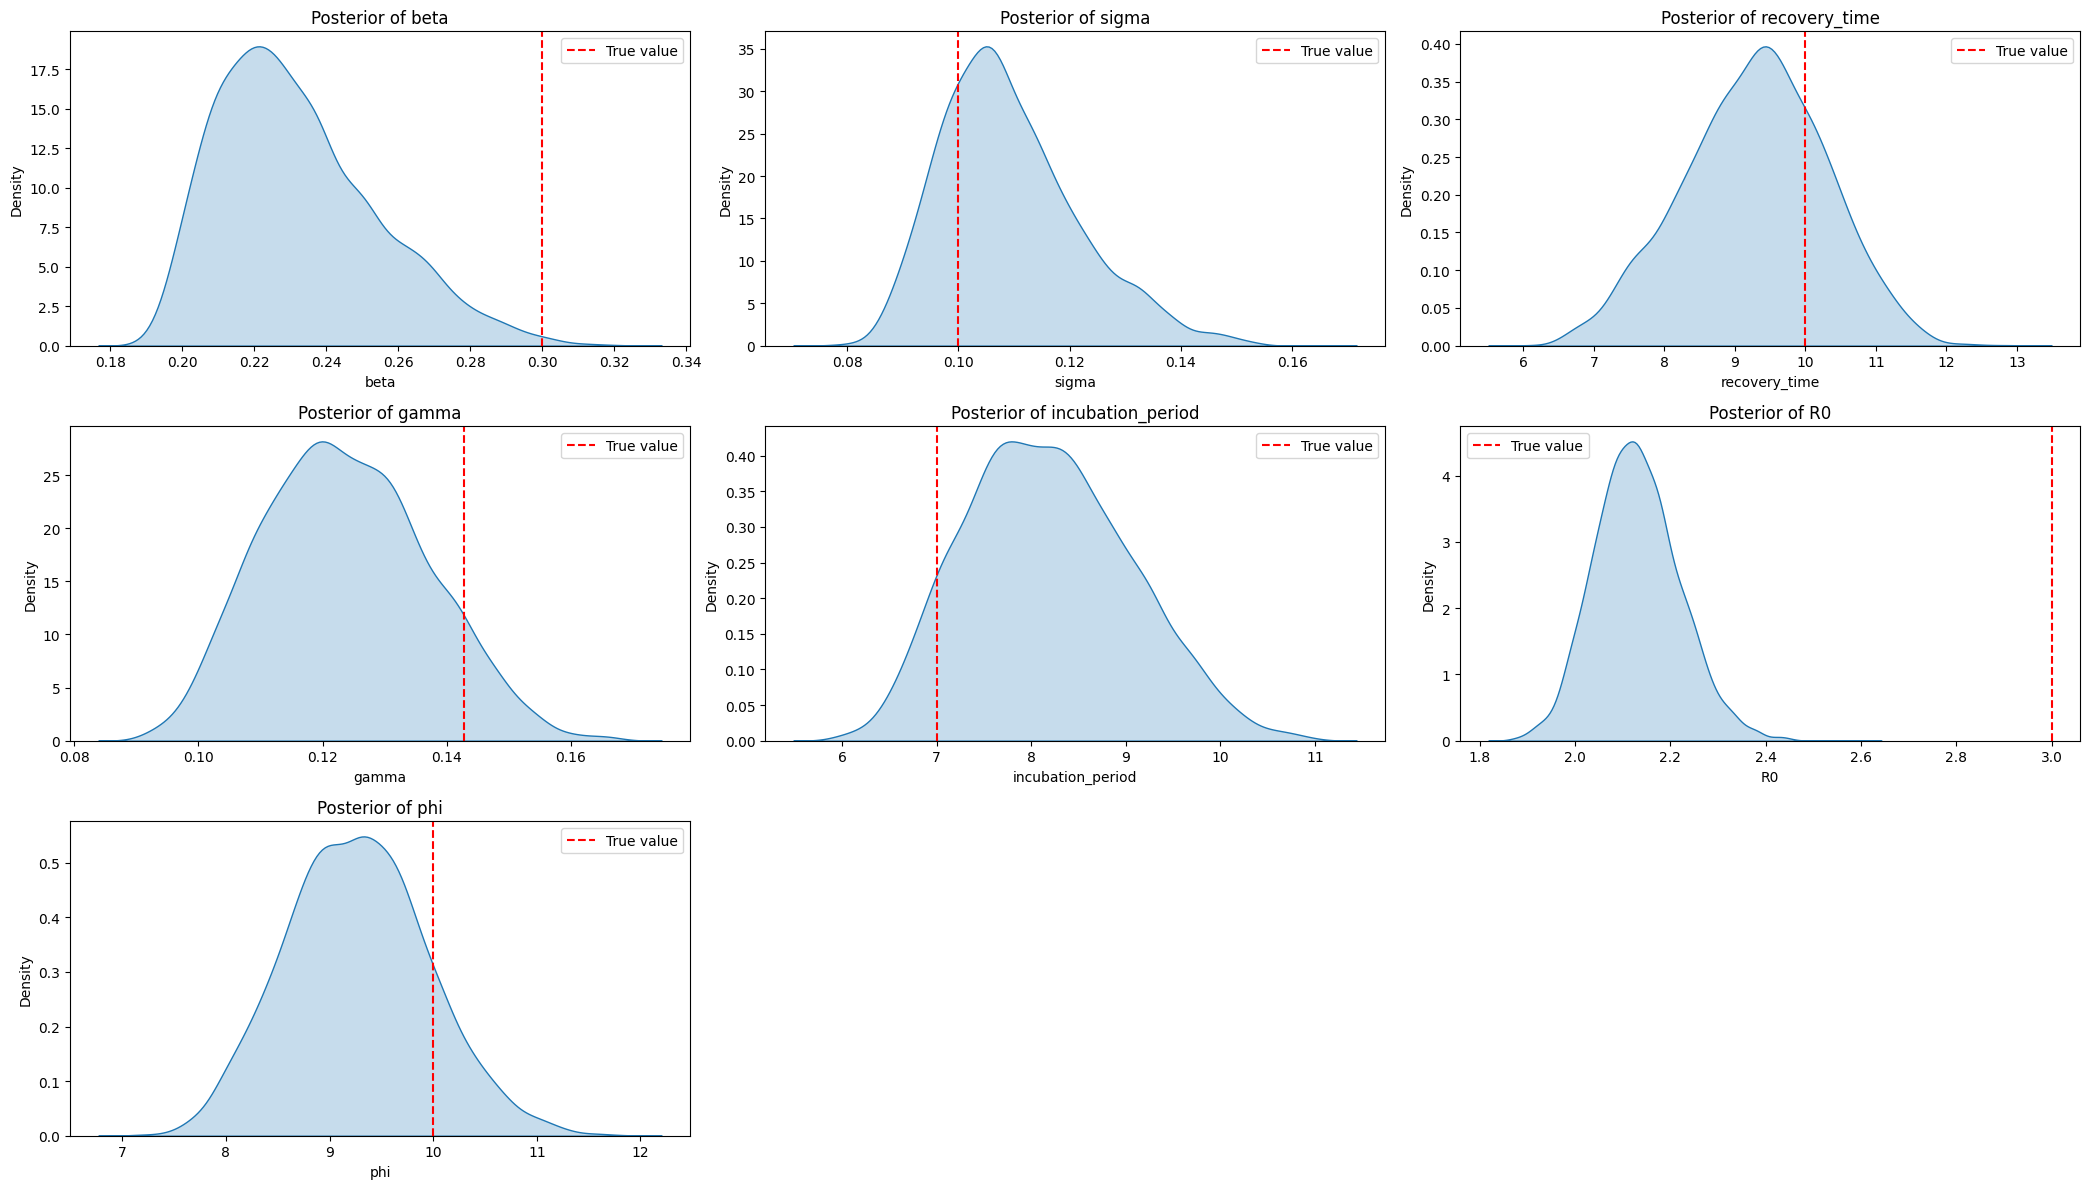

In [766]:
plot_posterior_kde_grid(fit_seir_incidence_model, parameters1, 2,3,t1)

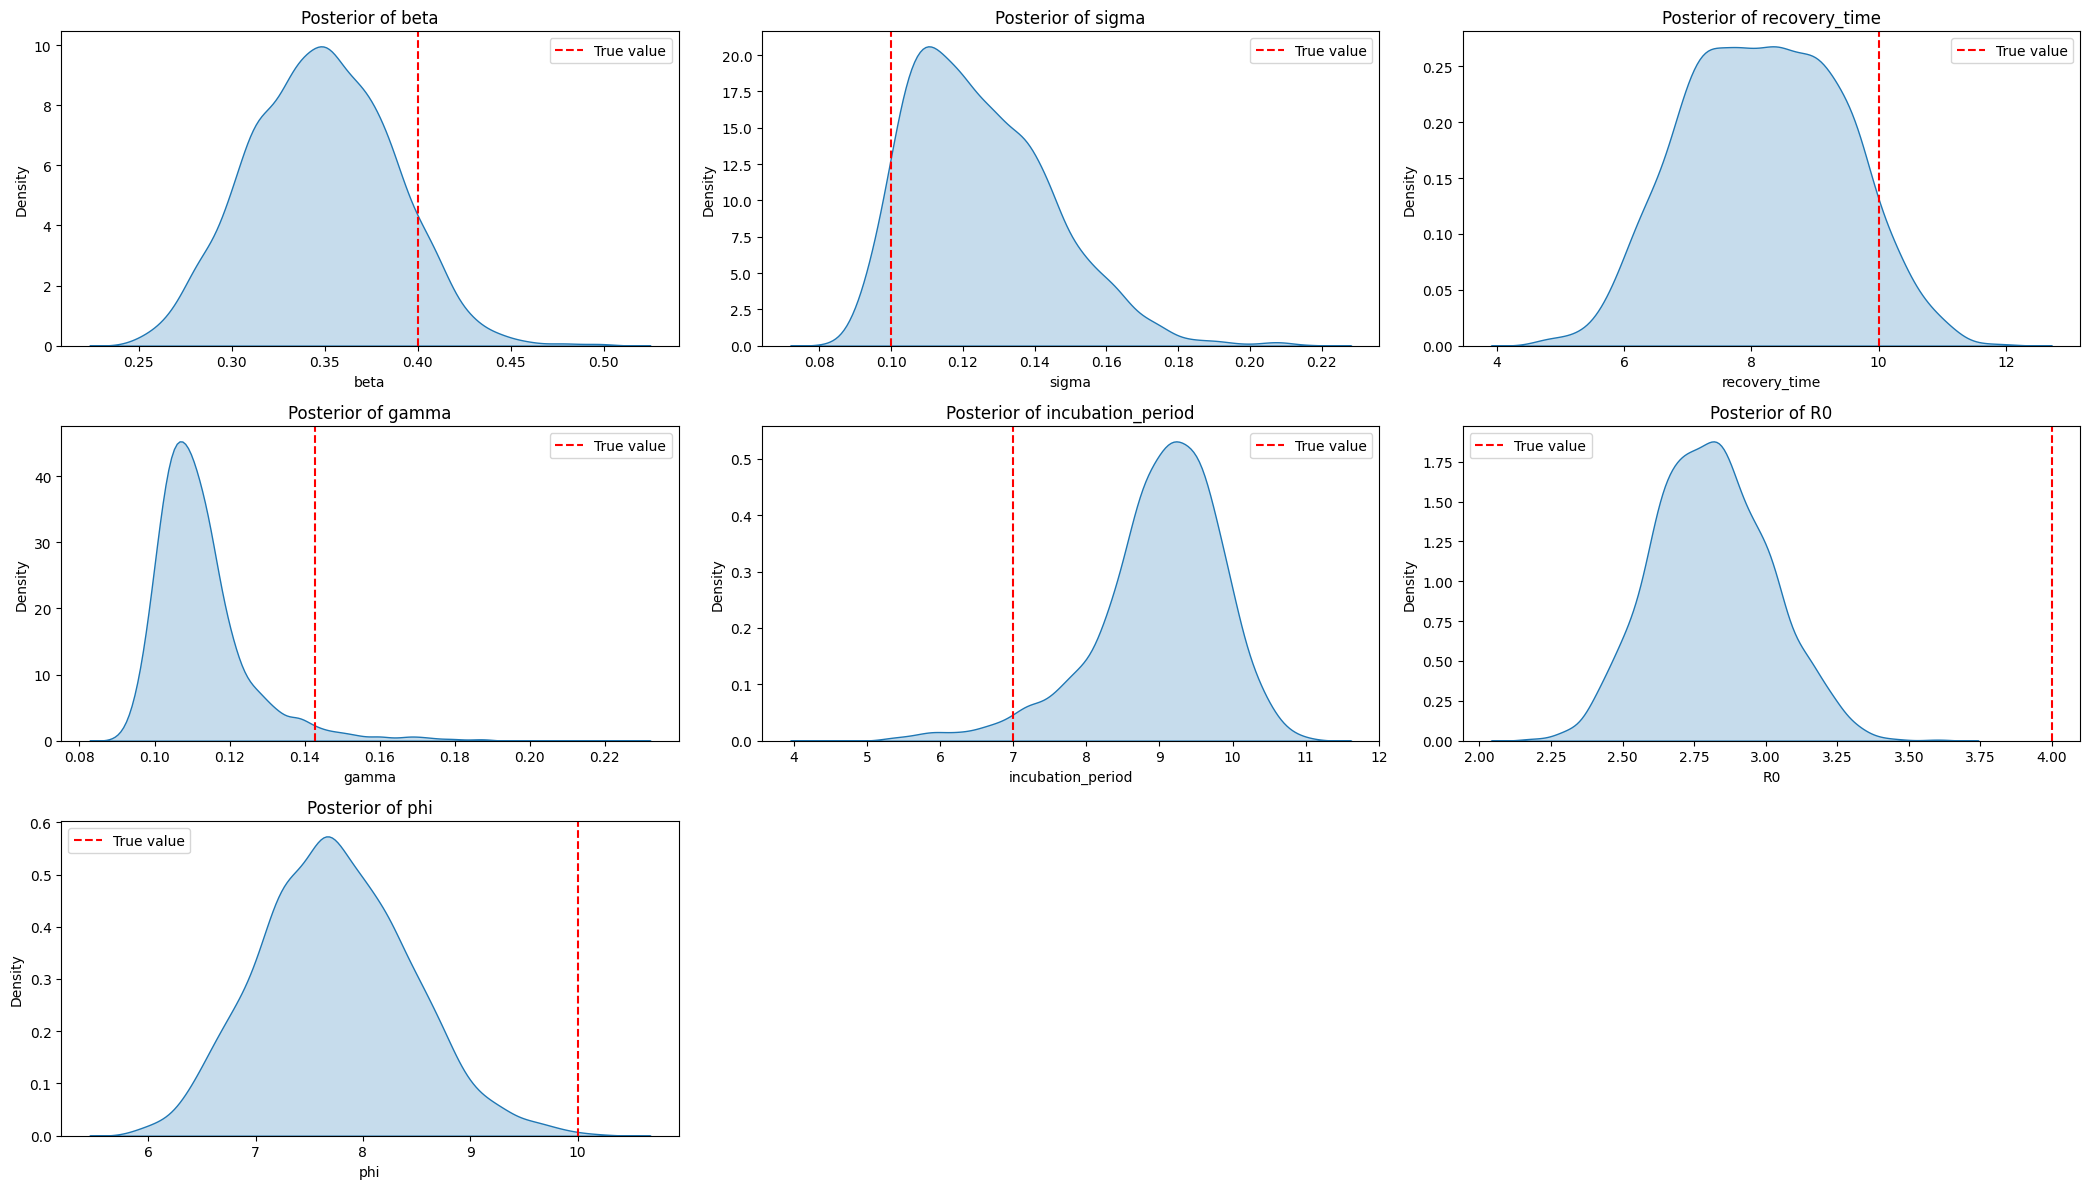

In [767]:
plot_posterior_kde_grid(fit2, parameters1, 2,3,t2)

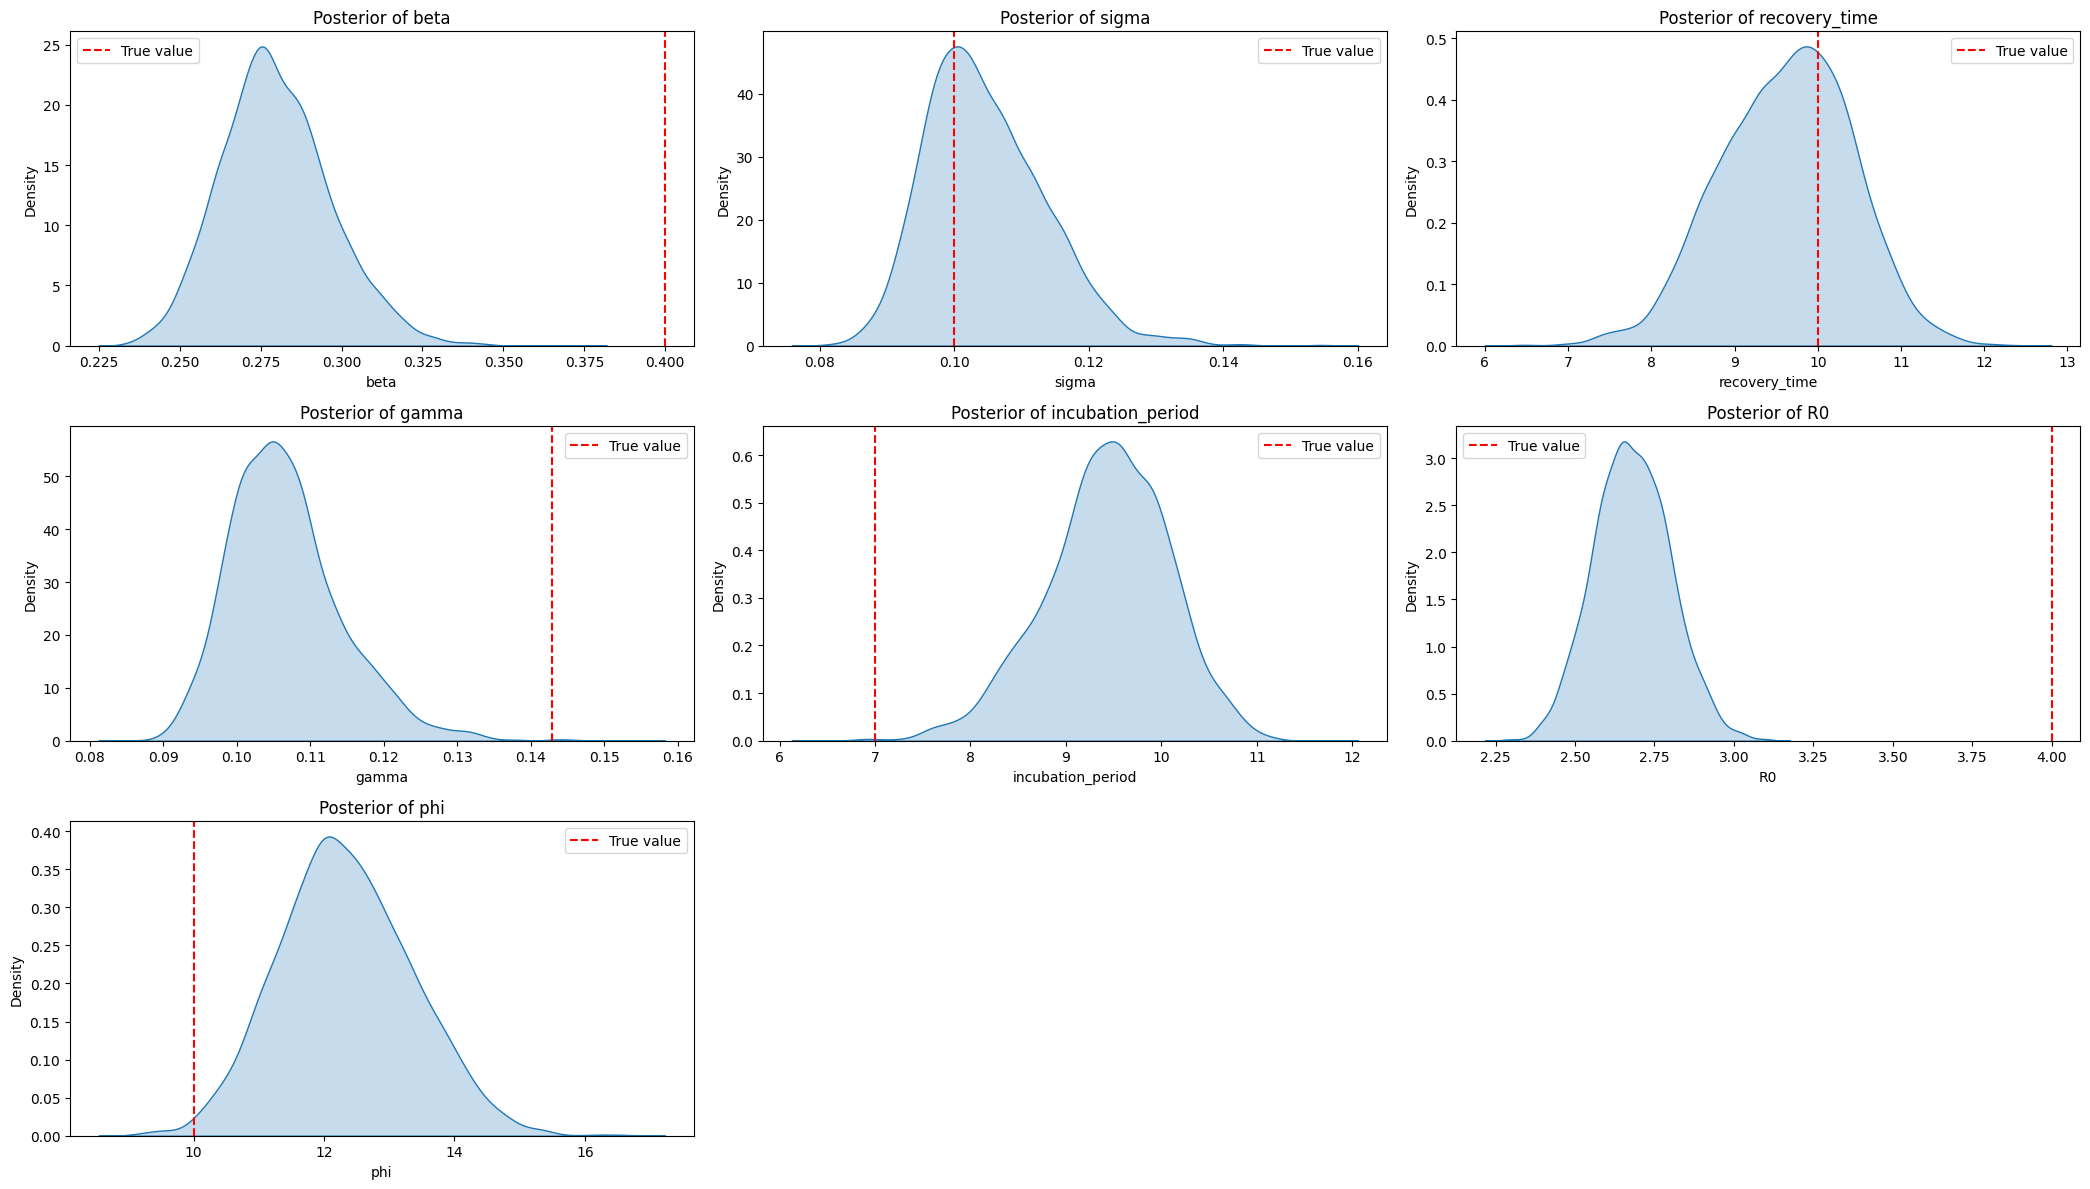

In [768]:
plot_posterior_kde_grid(fit3, parameters1, 2,3,t3)

## Plot SEIR Compartments

In [670]:

def plot_compartment(fit, country_idx):
    # Time points and countries
    weeks = np.arange(fit.stan_variable('incidence').shape[1])  # Number of weeks
    countries = ['Guinea', 'Liberia', 'Sierra Leone']

    # Plot incidence (infectious) and reconstructed other compartments
    # for i in range(countries):
    # Create figure
    plt.figure(figsize=(12, 7))
    incidence = np.mean(fit.stan_variable('incidence'), axis=0)

    # Reconstruct approximate compartments (scaled by reporting rate)
    I = incidence
    R = np.cumsum(I) * np.mean(fit.stan_variable('gamma'))
    E = np.roll(I, 1) / np.mean(fit.stan_variable('sigma'))  # Exposed ~ delayed infectious
    # E[0] = 0
    S = N[country_idx] - E - I - R

    # Convert to fractions
    S_frac = S / N[country_idx]
    E_frac = E / N[country_idx]
    I_frac = I / N[country_idx]
    R_frac = R / N[country_idx]

    # Plot
    plt.plot(weeks, S_frac, 'b', label='Susceptible')
    plt.plot(weeks, E_frac, 'y', label='Exposed')
    plt.plot(weeks, I_frac, 'r', label='Infectious')
    plt.plot(weeks, R_frac, 'g', label='Recovered')

    # Formatting
    plt.title(f'{countries[country_idx]} (R0={np.mean(fit.stan_variable("R0")):.2f})')
    plt.ylabel('Fraction of Population')
    plt.grid(True, alpha=0.3)
    # ax.set_ylim(0, 1)

    plt.legend(loc='upper right')
    plt.xlabel('Weeks since outbreak start')
    # plt.tight_layout()
    plt.show()                                                                                      

In [769]:
# plot_compartment(fit_seir_incidence_model, country_idx=0)
# plot_compartment(fit2, country_idx=1)
# plot_compartment(fit3, country_idx=2)

# FITTING FOR 3 PATCHES

In [677]:
weekly = raw[['Guinea_Noise', 'Liberia_Noise', 'SierraLeone_Noise']]
weekly.head()

,Guinea_Noise,Liberia_Noise,SierraLeone_Noise
0,0,0,0
1,6,4,2
2,44,2,7
3,96,11,6
4,61,7,5


In [700]:
weekly.values.T

array([[ 0,  6, 44, ...,  1,  2,  0],
       [ 0,  4,  2, ...,  0,  0,  0],
       [ 0,  2,  7, ...,  0,  0,  0]], shape=(3, 450))

In [843]:

N = np.array([11.5e6, 4.5e6, 6.8e6]) 
# Set the population size

# Define initial conditions
g0 = [N[0]-1000, 10, 1000, 0, 1000]
l0 = [N[1]-100, 10, 100, 0, 100]
s0 = [N[2]-100, 10, 100, 0, 100]

ts = weekly.values.T
y0 = [g0, l0, s0]

# Make the data struture
seir_data = {
    'N_countries': 3,
    "n_days": len(ts[0]),
    'y0': y0,
    't0': 0,
    "t": np.arange(1, len(ts[0])+1),
    "N": N.astype(int),
    "cases": ts,
}

multi_model = CmdStanModel(stan_file = 'stan files/mult.stan')

In [844]:
fit_multi_model = multi_model.sample(data = seir_data,
                                     iter_sampling = 1000,
                                     chains = 4,
                                     seed = 0)

KeyboardInterrupt: 

In [777]:
print(fit_multi_model.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  beta[1], beta[2], beta[3], sigma, gamma, phi_inv, reporting_rate[1], reporting_rate[3], y[2,1,1], y[2,3,1], y[1,4,1], y[2,4,1], y[3,4,1], y[2,5,1], y[3,5,1], y[1,6,1], y[2,6,1], y[3,6,1], y[2,7,1], y[3,7,1], y[1,8,1], y[2,8,1], y[3,8,1], y[1,9,1], y[2,9,1], y[3,9,1], y[1,10,1], y[2,10,1], y[3,10,1], y[1,11,1], y[2,11,1], y[3,11,1], y[1,12,1], y[2,12,1], y[3,12,1], y[1,13,1], y[2,13,1], y[3,13,1], y[1,14,1], y[2,14,1], y[3,14,1], y[1,15,

In [778]:
multy_fit_summary = fit_multi_model.summary()
multy_fit_summary.filter(items=("beta[1]","beta[2]", "beta[3]", "sigma", "recovery_time",
                                 "gamma", "incubation_period", "R0[1]","R0[2]", "R0[3]",
                                   "phi", "phi_inv"), axis=0)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
beta[1],0.221047,0.032133,0.047023,0.023922,0.141215,0.240496,0.269566,7.35157,2000.0,1.52774
beta[2],0.316805,0.025520,0.039591,0.031869,0.252444,0.329230,0.366810,7.35602,2000.0,1.52751
beta[3],0.267320,0.031019,0.046063,0.027823,0.190030,0.285022,0.318367,7.37370,2000.0,1.52751
sigma,0.085028,0.028800,0.041308,0.013065,0.014188,0.104341,0.121590,7.31580,2000.0,1.52882
recovery_time,24.109500,18.155100,25.738300,1.153090,8.224360,9.583940,70.479700,7.31582,2000.0,1.52890
gamma,0.091110,0.013570,0.019857,0.008213,0.057635,0.098887,0.112296,7.39299,2000.0,1.53120
incubation_period,11.676400,2.265970,3.241910,0.819463,8.905040,10.112600,17.350500,7.39294,2000.0,1.53125
R0[1],4.159120,2.297100,3.255430,0.111610,2.177470,2.309400,9.977430,7.18878,2000.0,1.52779
R0[2],6.713460,4.402230,6.239680,0.191693,2.937080,3.163780,17.927600,7.19407,2000.0,1.52776
R0[3],5.316960,3.201420,4.537520,0.148801,2.561080,2.737840,13.468600,7.19516,2000.0,1.52777


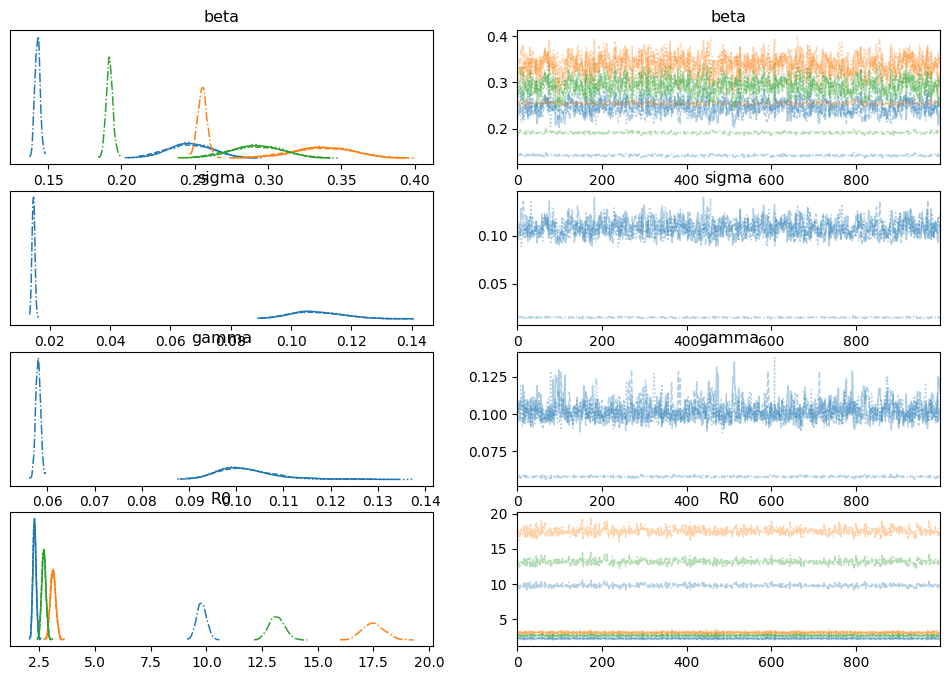

In [779]:

az.plot_trace(fit_multi_model, var_names=["beta", "sigma", "gamma", "R0"])
plt.show()

In [780]:
# Assuming `fit` is your CmdStanMCMC object from fitting the model
posterior_samples = fit_multi_model.draws_pd()  # returns a pandas DataFrame
parameters = ["beta[1]","beta[2]", "beta[3]", 
              "sigma", "recovery_time",
                "gamma", "incubation_period", 
                "R0[1]","R0[2]", "R0[3]",
                  "phi"]

beta = np.array([0.3, 0.4, 0.35])  # Transmission rate (R0 = beta/gamma)
sigma = 1/10         # 1/latent period (Ebola: ~10 days) Average value
gamma = 1/7         # 1/infectious period (Ebola: ~7 days)
phi = 10            # Negative binomial dispersion parameter
reporting_rate = 0.8
r = beta/sigma
rec = 1.0/sigma
incu = 1.0 / gamma

t = {
    'beta[1]': beta[0],
    'beta[2]': beta[1],
    'beta[3]': beta[2],
    'sigma': 1/10,   
    'gamma': 1/7,
    'phi': 10 ,
    'reporting_rate':0.8,
    'R0[1]': r[0], 'R0[2]': r[1], 'R0[3]': r[2], 
    'recovery_time':rec,
    'incubation_period': incu}

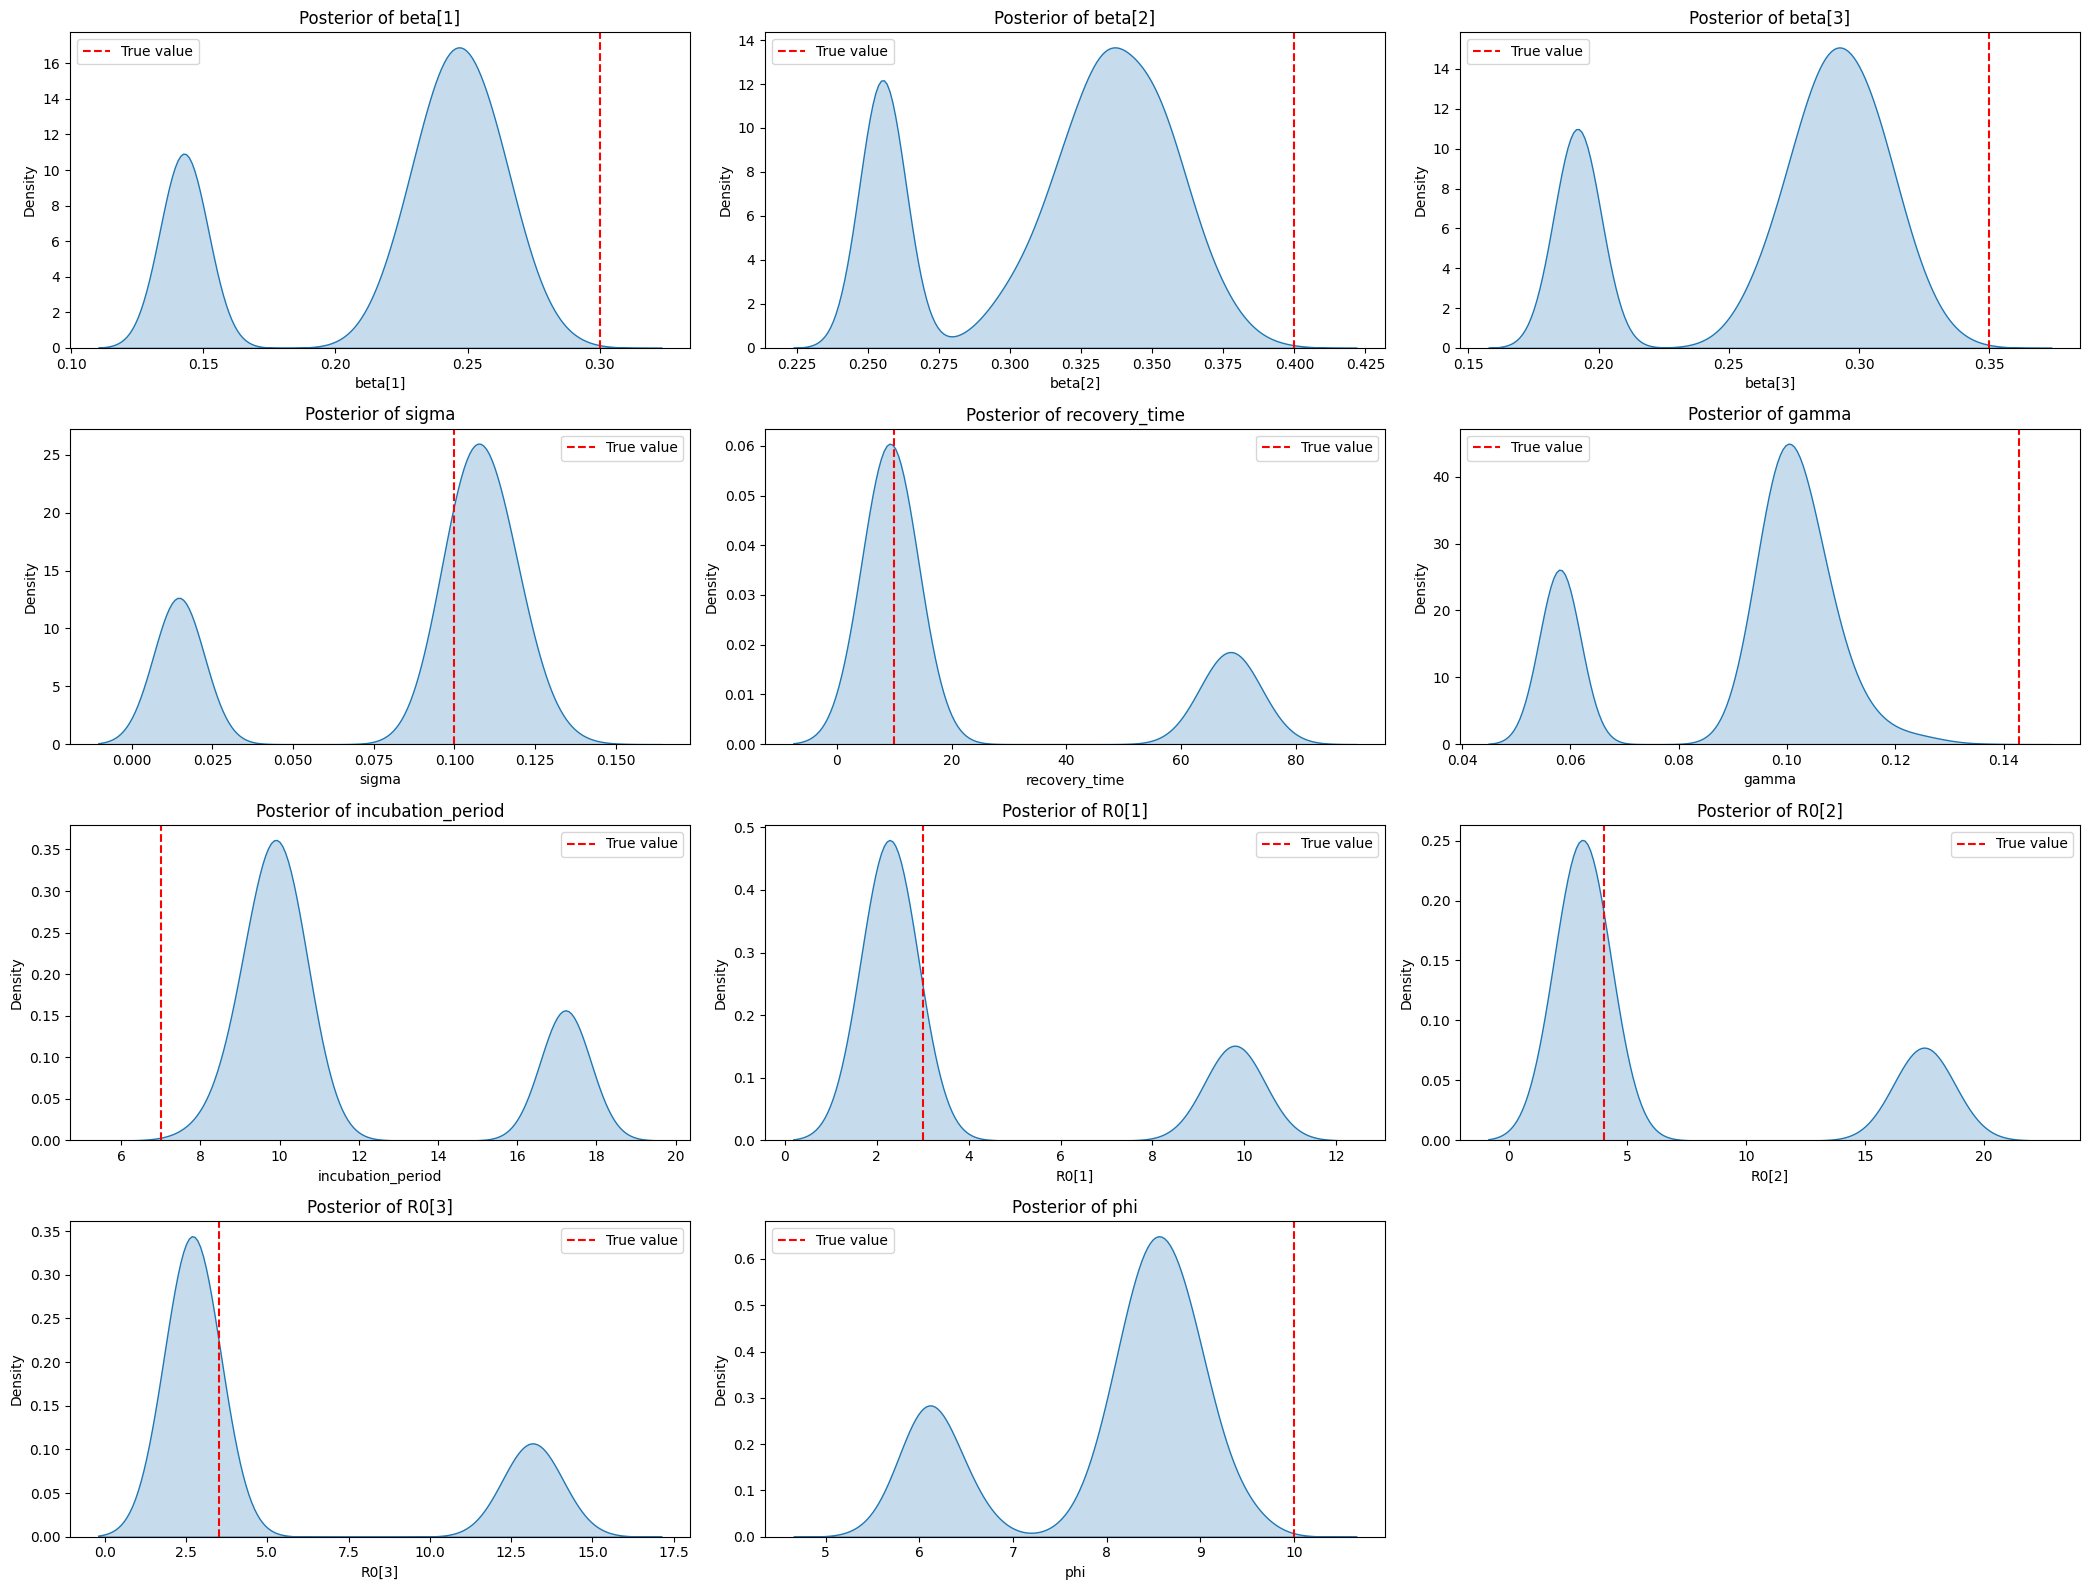

In [781]:
plot_posterior_kde_grid(fit_multi_model, parameters=parameters, 
                        n_rows=3, n_cols=3, true_values=t)

In [ ]:

# N = np.array([11.5e6, 4.5e6, 6.8e6]) 
# # Set the population size

# # Define initial conditions
# g0 = [N[0]-1000, 0, 1000, 0, 1000]
# l0 = [N[1]-1000, 0, 100, 0, 100]
# s0 = [N[2]-1000, 0, 100, 0, 100]

# ts2 = noisy_cases.values.T
# y0 = [g0, l0, s0]

# # Make the data struture
# seir_data2 = {
#     'N_countries': 3,
#     "n_days": len(ts2[0]),
#     'y0': y0,
#     't0': 0,
#     "t": np.arange(1, len(ts2[0])+1),
#     "N": N.astype(int),
#     "cases": ts2,
# }

# multi_model_weekly = CmdStanModel(stan_file = 'stan files/mult.stan')

In [ ]:
# fit_weekly_model = multi_model_weekly.sample(data = seir_data2,
#                                     #  iter_sampling = 1000,
#                                      chains = 4,
#                                      seed = 0)

chain 1 |          | 00:00 Status

chain 3 |          | 00:00 Status





chain 1 |████▌     | 17:42 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |██████████| 22:53 Iteration: 1900 / 2000 [ 95%]  (Sampling)



























KeyboardInterrupt: 

In [ ]:
#print(fit_weekly_model.diagnose())

Checking sampler transitions treedepth.
1000 of 1000 (100.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  y[1,24,2], y[1,25,2], y[1,26,2], y[1,27,2], y[1,28,2], y[1,29,2], y[1,30,2], y[1,31,2], y[1,32,2], y[1,33,2], y[1,34,2], y[1,35,2], y[1,36,2], y[1,37,2], y[1,39,2], y[1,40,2], y[1,41,2], y[1,42,2], y[1,43,2], y[1,44,2], y[1,45,2], y[1,46,2], y[

In [ ]:
# weekly_summary = fit_weekly_model.summary()
# weekly_summary.filter(items=("beta[1]","beta[2]", "beta[3]", "sigma", "recovery_time",
#                                  "gamma", "incubation_period", "R0[1]","R0[2]", "R0[3]",
#                                    "phi", "phi_inv"), axis=0)
   

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
beta[1],1.543720,NaN,0.778351,0.200855,0.211601,1.922660,2.20928,NaN,NaN,NaN
beta[2],3.176590,NaN,0.978910,0.354015,1.516140,3.616840,4.08569,NaN,NaN,NaN
beta[3],2.676710,NaN,0.142840,0.103952,2.453830,2.646370,2.94615,NaN,NaN,NaN
sigma,0.529545,NaN,0.429379,0.089934,0.202562,0.303241,1.26815,NaN,NaN,NaN
recovery_time,2.957970,NaN,1.425180,1.046620,0.788550,3.297720,4.93676,NaN,NaN,NaN
gamma,0.769577,NaN,0.748714,0.018191,0.320559,0.342146,2.06611,NaN,NaN,NaN
incubation_period,2.346480,NaN,1.079010,0.157964,0.484000,2.922730,3.11956,NaN,NaN,NaN
R0[1],5.465230,NaN,3.219540,1.528220,0.166858,6.651250,9.03772,NaN,NaN,NaN
R0[2],10.538600,NaN,5.868410,3.453380,1.195560,12.301100,17.75610,NaN,NaN,NaN
R0[3],7.876890,NaN,3.669980,2.270800,2.086800,8.926390,12.57840,NaN,NaN,NaN


In [ ]:

# az.plot_trace(fit_weekly_model, var_names=["beta", "sigma", "gamma", "R0"])
# plt.show()